# Human Activity Recognition

In [6]:
import os
import cv2
import time
import csv
import tqdm
import numpy as np

import mediapipe as mp
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose

## Preparación imagenes

In [2]:
rutaVideos = "../Dataset/UCF101/LongJump"

In [21]:
# Abrir video y extraer frames
cap= cv2.VideoCapture("../Dataset/UCF101/LongJump/v_LongJump_g01_c01.avi")
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('../Dataset/LongJumpFrames/longjump_'+str(i)+'.jpg',frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

In [24]:
# Renombrar frames para saber que accion esta realizando
arr = sorted(os.listdir("../Dataset/LongJumpFrames/salto"),key=len)
arr.sort()

i=0
for img in arr:
    os.rename("../Dataset/LongJumpFrames/salto/"+img, "../Dataset/LongJumpFrames/salto/"+"salto_"+str(i)+".jpg")
    i+=1

In [ ]:
labels = ["correr","batida","salto"]

## Mediapipe

In [2]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()

mpDraw = mp.solutions.drawing_utils


cap = cv2.VideoCapture("../Dataset/UCF101/LongJump/v_LongJump_g01_c01.avi")
pTime = 0
count = 0
while(cap.isOpened()):
    success, img = cap.read()
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)

    print(results.pose_landmarks)

    if results.pose_landmarks:
        mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = img.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            cv2.circle(img, (cx,cy), 5, (255,0,0), cv2.FILLED)

    cTime = time.time()
    fps = 1/(cTime-pTime)
    pTime = cTime

    cv2.putText(img, str(int(fps)), (70,50), cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)

    # cv2.imwrite("frames/img_"+str(count)+".jpg",img)
    count+=1
    # cv2.waitKey(10)

y: 0.6726897
  z: 0.18219993
  visibility: 0.12831905
}
landmark {
  x: 0.49988404
  y: 0.69824463
  z: -0.13009198
  visibility: 0.95984864
}
landmark {
  x: 0.46785626
  y: 0.7753135
  z: 0.2995372
  visibility: 0.33520833
}
landmark {
  x: 0.43630037
  y: 0.8068018
  z: -0.0705113
  visibility: 0.9148783
}
landmark {
  x: 0.45700732
  y: 0.7854761
  z: 0.30714485
  visibility: 0.35959956
}
landmark {
  x: 0.4185987
  y: 0.81654143
  z: -0.06686213
  visibility: 0.87441915
}
landmark {
  x: 0.47856504
  y: 0.81992036
  z: 0.27146757
  visibility: 0.44714633
}
landmark {
  x: 0.44183707
  y: 0.85334116
  z: -0.12391355
  visibility: 0.8374089
}

landmark {
  x: 0.5519311
  y: 0.34335086
  z: -0.23404689
  visibility: 1.0
}
landmark {
  x: 0.5489489
  y: 0.3261491
  z: -0.22418098
  visibility: 1.0
}
landmark {
  x: 0.547643
  y: 0.32507867
  z: -0.22424558
  visibility: 1.0
}
landmark {
  x: 0.54646754
  y: 0.32395253
  z: -0.22409935
  visibility: 1.0
}
landmark {
  x: 0.5491896
  y:

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Crear dataset

Clases run, batida, salto

In [5]:
images_in_folder = '../Dataset/LongJumpFrames'
images_out_folder = '../Dataset/LongJumpFrames_out'

# Output CSV format:
#   sample_00001,pose_class_1,x1,y1,z1,x2,y2,z2,...,x33,y33,z33
#   sample_00002,pose_class_2,x1,y1,z1,x2,y2,z2,...,x33,y33,z33
#   ...
#
csv_out_path = 'pose_csv/longjump_poses_csvs_out_basic.csv'

In [6]:
with open(csv_out_path, 'w', newline='') as csv_out_file:
  csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

  # Folder names are used as pose class names.
  pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])

  for pose_class_name in pose_class_names:
    print('Bootstrapping ', pose_class_name, file=sys.stderr)

    if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
      os.makedirs(os.path.join(images_out_folder, pose_class_name))

    image_names = sorted([
        n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
        if not n.startswith('.')])
    for image_name in tqdm.tqdm(image_names, position=0):
      # Load image.
      input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
      input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

      # Initialize fresh pose tracker and run it.
      with mp_pose.Pose(upper_body_only=False) as pose_tracker:
        result = pose_tracker.process(image=input_frame)
        pose_landmarks = result.pose_landmarks
      
      # Save image with pose prediction (if pose was detected).
      output_frame = input_frame.copy()
      if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)
      output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
      cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
      
      # Save landmarks.
      if pose_landmarks is not None:
        # Check the number of landmarks and take pose landmarks.
        assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

        # Map pose landmarks from [0, 1] range to absolute coordinates to get
        # correct aspect ratio.
        frame_height, frame_width = output_frame.shape[:2]
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])

        # Write pose sample to CSV.
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()
        csv_out_writer.writerow([image_name, pose_class_name] + pose_landmarks)

Bootstrapping  batida
100%|██████████| 8/8 [00:00<00:00, 12.15it/s]
Bootstrapping  correr
100%|██████████| 69/69 [00:05<00:00, 12.25it/s]
Bootstrapping  salto
100%|██████████| 66/66 [00:04<00:00, 13.36it/s]


### Filtrar outliers

In [1]:
import os
import cv2
import time
import csv
import tqdm
import numpy as np

import mediapipe as mp
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose

from src.EMADictSmoothing import EMADictSmoothing
from src.FullBodyPoseEmbedder import FullBodyPoseEmbedder
from src.PoseClassificationVisualizaer import PoseClassificationVisualizer
from src.PoseClassifier import PoseClassifier
from src.RepetitionCounter import RepetitionCounter
from src.BoostrapHelper import BootstrapHelper

In [2]:
bootstrap_images_in_folder = '../Dataset/LongJumpFrames'

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = '../Dataset/LongJumpFrames_out'
bootstrap_csvs_out_folder = 'pose_csv'

bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [5]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

Number of images per pose class:
  batida: 8
  correr: 69
  salto: 66


In [6]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=None)

Bootstrapping  batida
100%|██████████| 8/8 [00:00<00:00, 11.68it/s]
Bootstrapping  correr
100%|██████████| 69/69 [00:05<00:00, 12.33it/s]
Bootstrapping  salto
100%|██████████| 66/66 [00:05<00:00, 13.07it/s]


In [7]:
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  batida: 6
  correr: 46
  salto: 39


In [3]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedder()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

Number of outliers:  3


Outlier
  sample path =     ../Dataset/LongJumpFrames_out\batida\batida_0.jpg
  sample class =    batida
  detected class =  ['correr']
  all classes =     {'batida': 2, 'correr': 8}


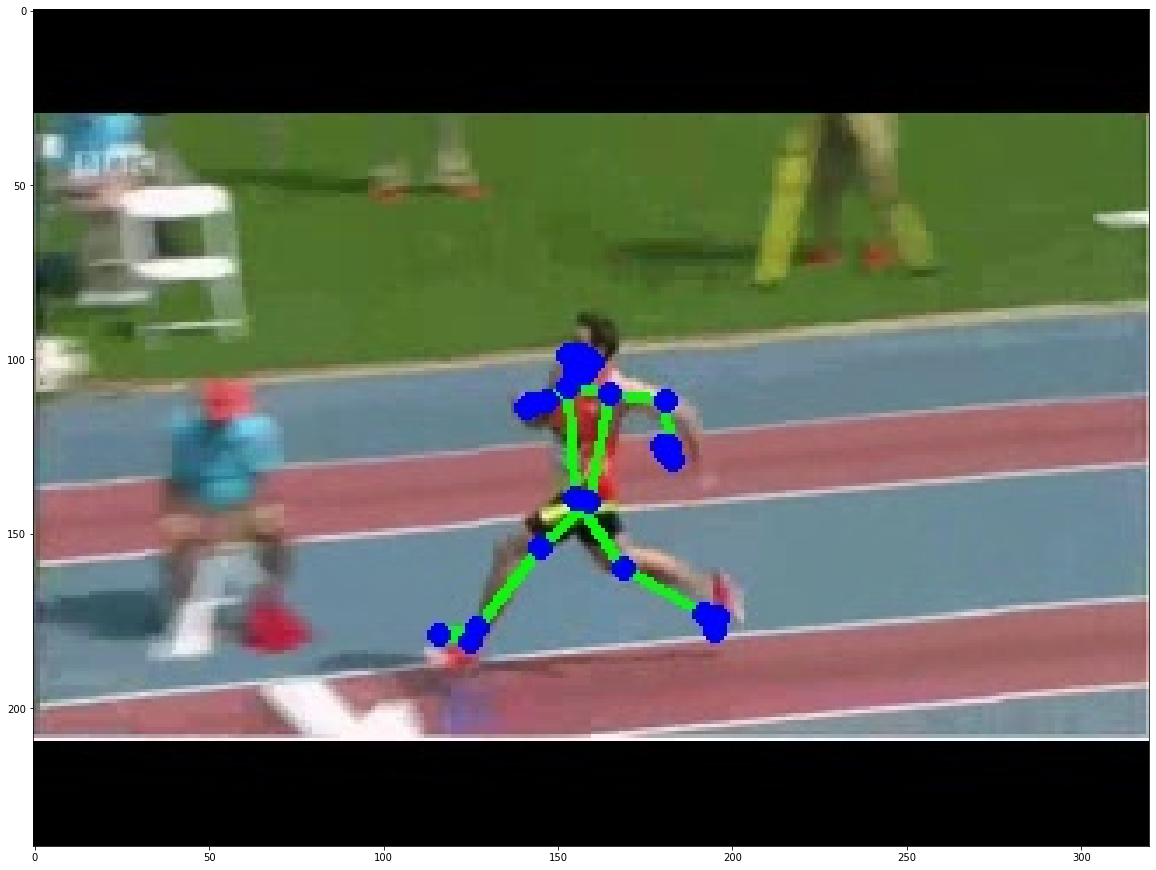

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\batida\batida_1.jpg
  sample class =    batida
  detected class =  ['correr']
  all classes =     {'batida': 2, 'salto': 1, 'correr': 7}


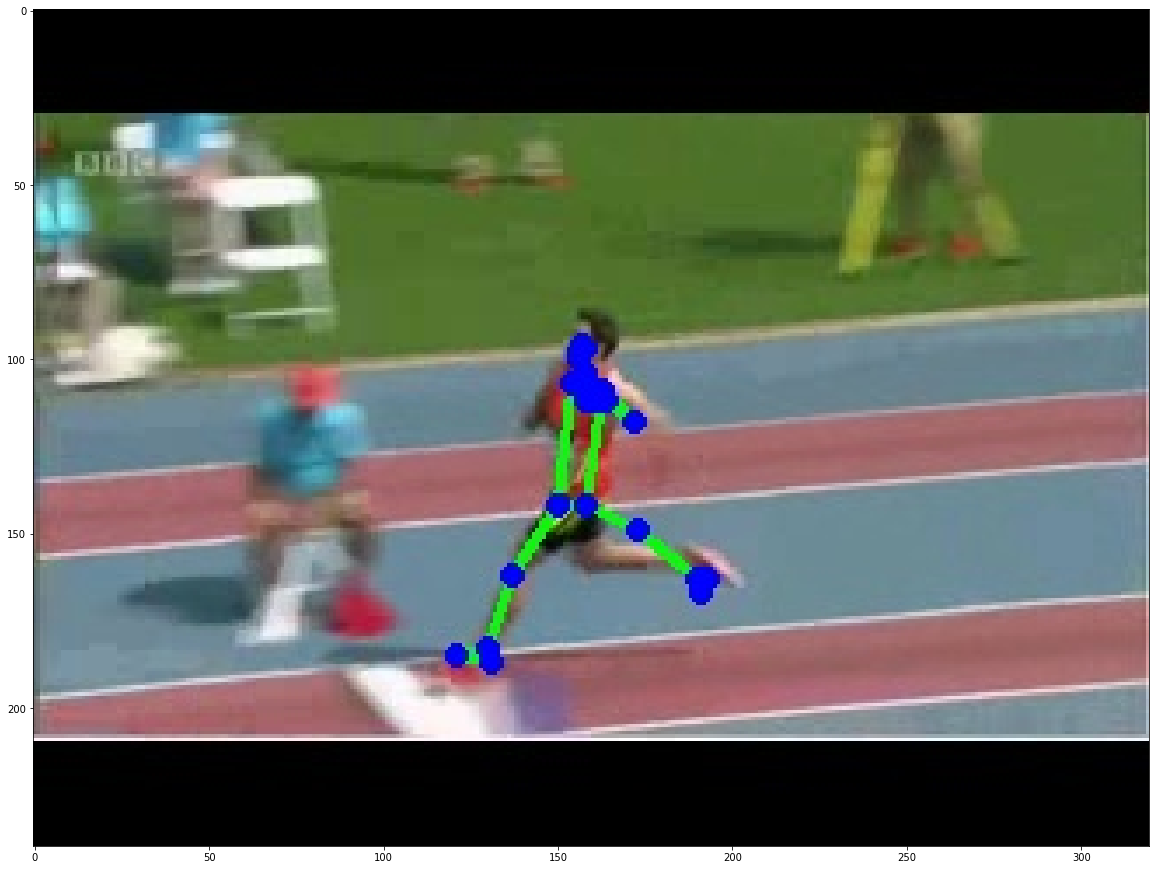

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\batida\batida_2.jpg
  sample class =    batida
  detected class =  ['correr']
  all classes =     {'batida': 4, 'salto': 1, 'correr': 5}


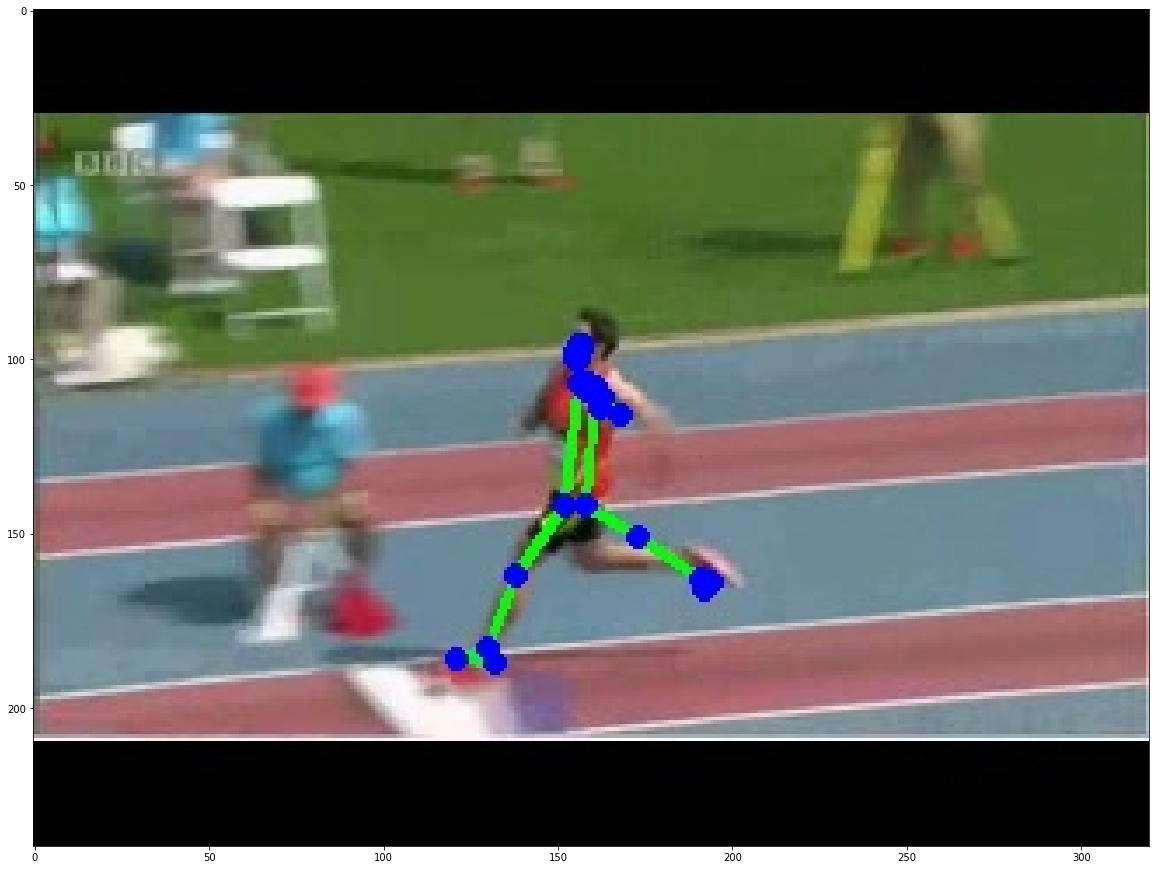

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\batida\batida_4.jpg
  sample class =    batida
  detected class =  ['salto']
  all classes =     {'batida': 1, 'salto': 5, 'correr': 4}


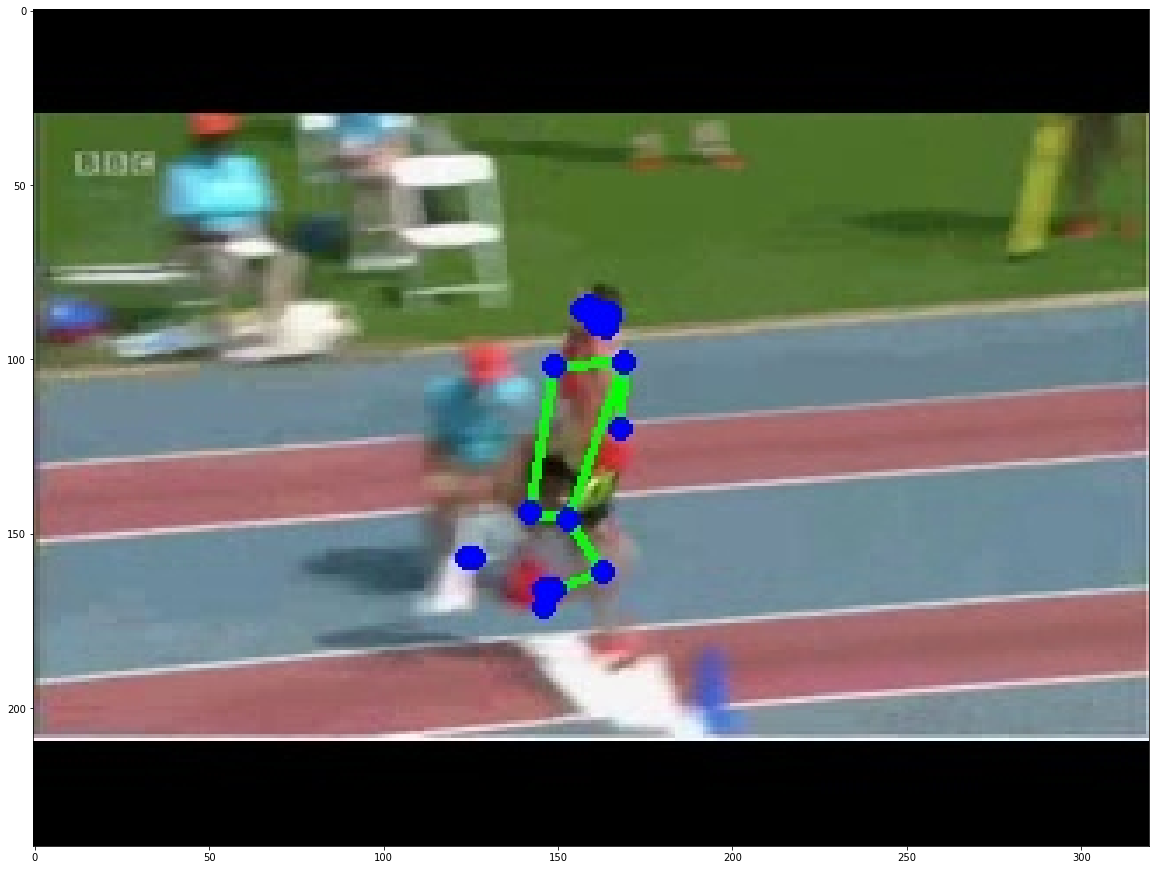

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\correr\run_18.jpg
  sample class =    correr
  detected class =  ['salto']
  all classes =     {'salto': 7, 'correr': 3}


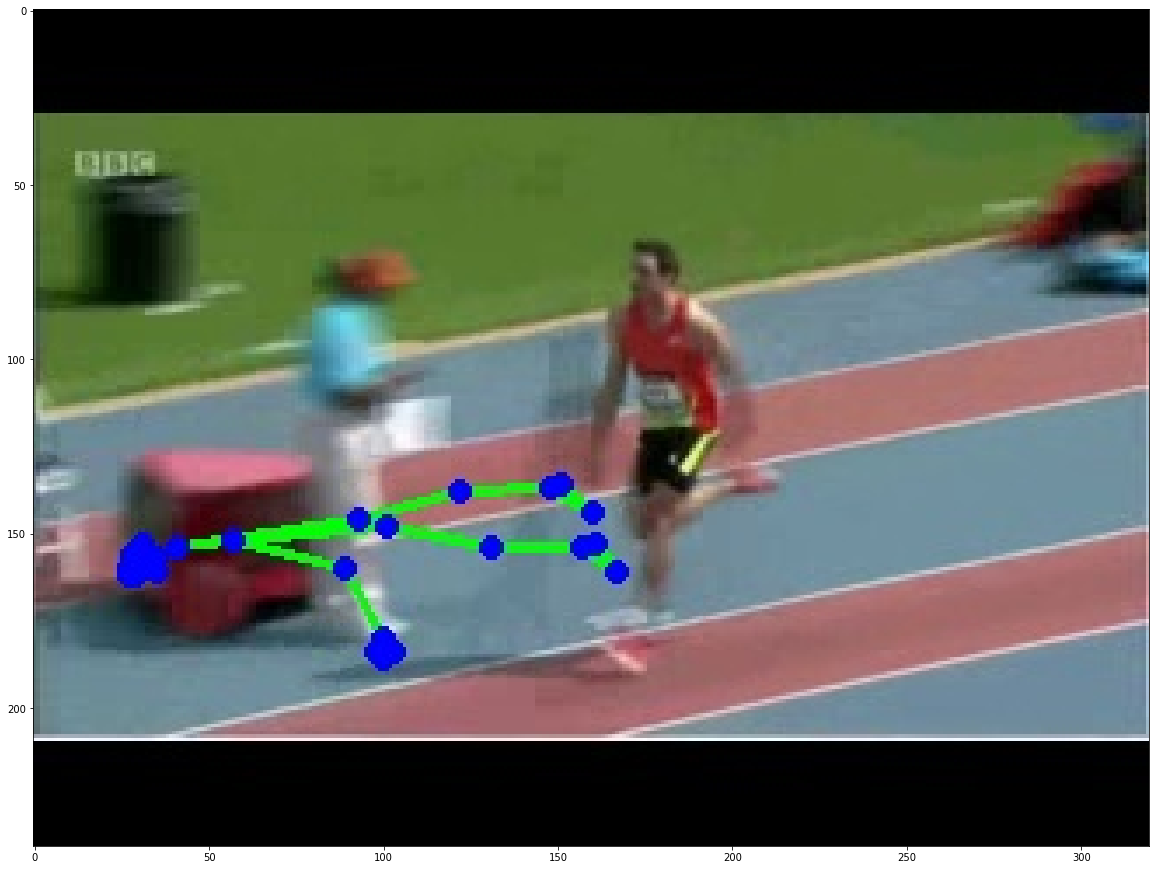

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\correr\run_43.jpg
  sample class =    correr
  detected class =  ['salto']
  all classes =     {'salto': 7, 'correr': 3}


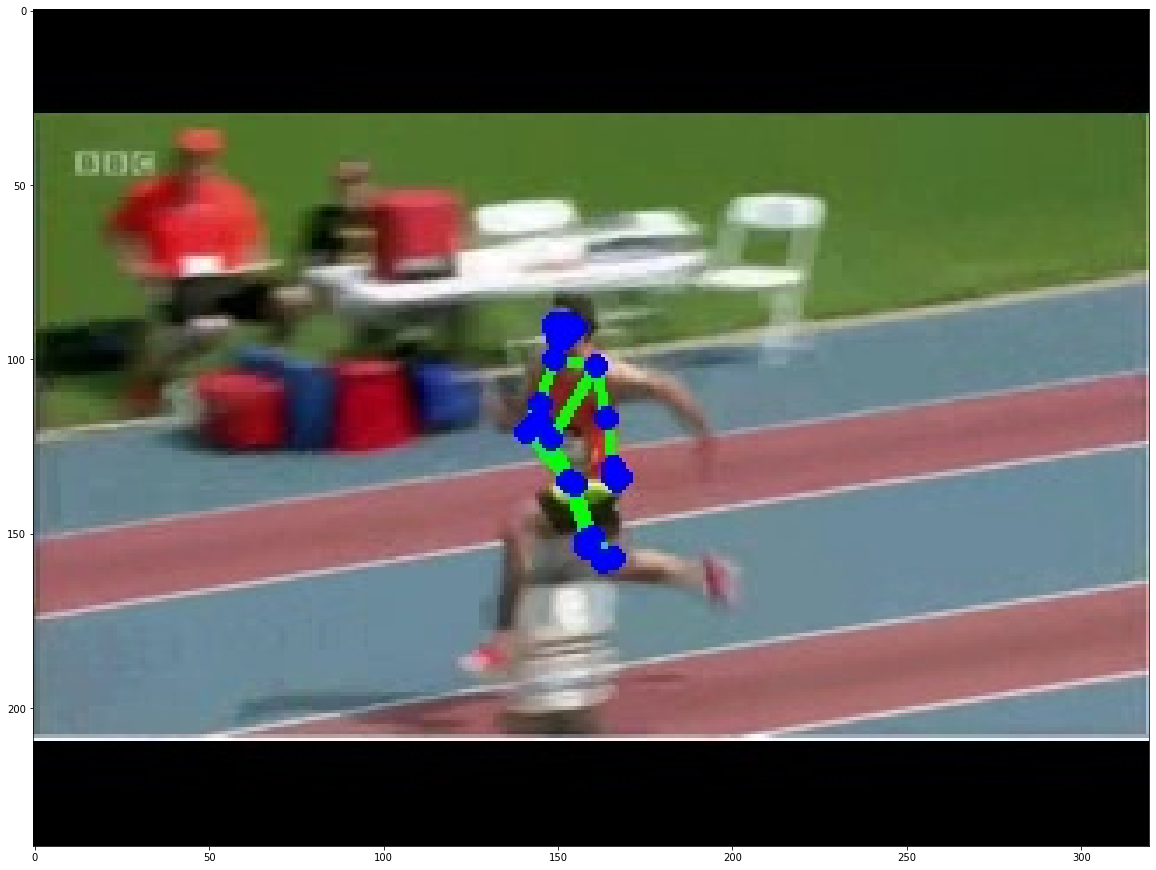

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\salto\salto_12.jpg
  sample class =    salto
  detected class =  ['correr']
  all classes =     {'salto': 2, 'correr': 8}


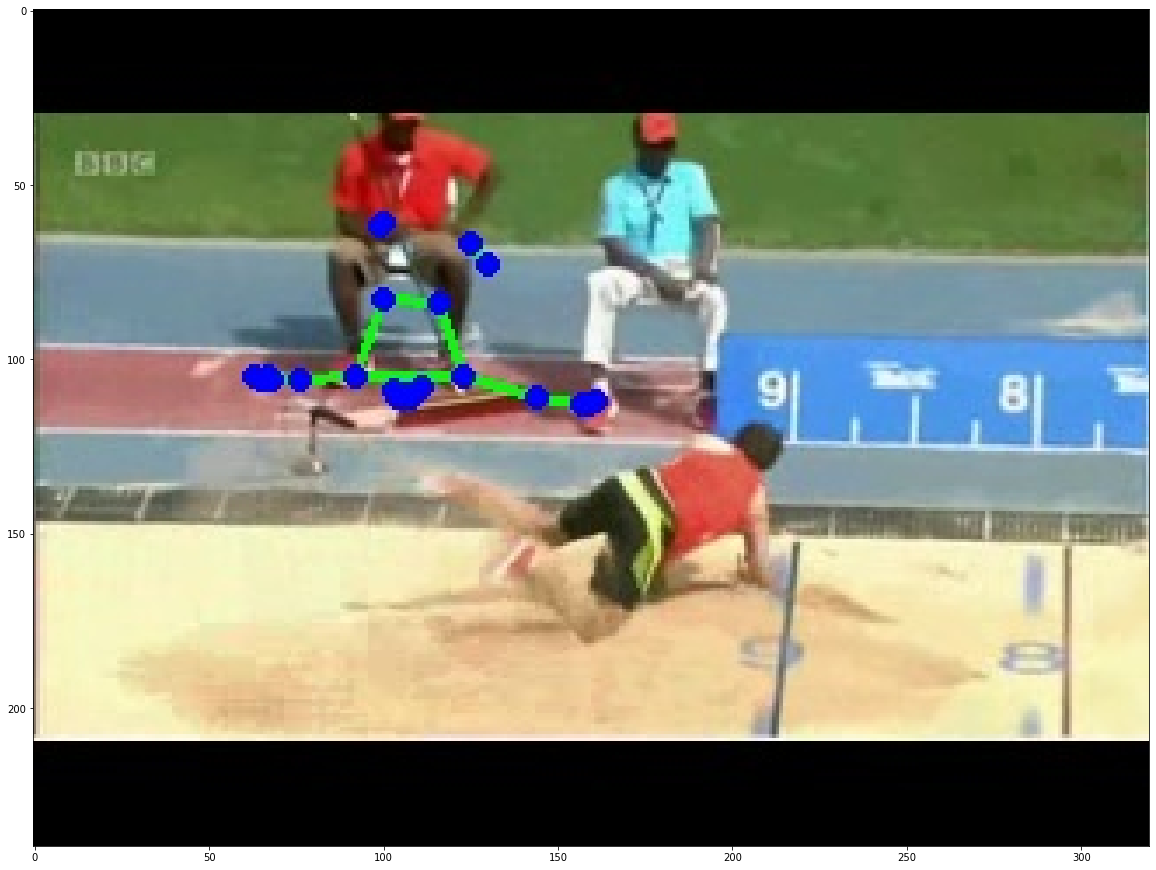

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\salto\salto_43.jpg
  sample class =    salto
  detected class =  ['correr']
  all classes =     {'batida': 4, 'salto': 1, 'correr': 5}


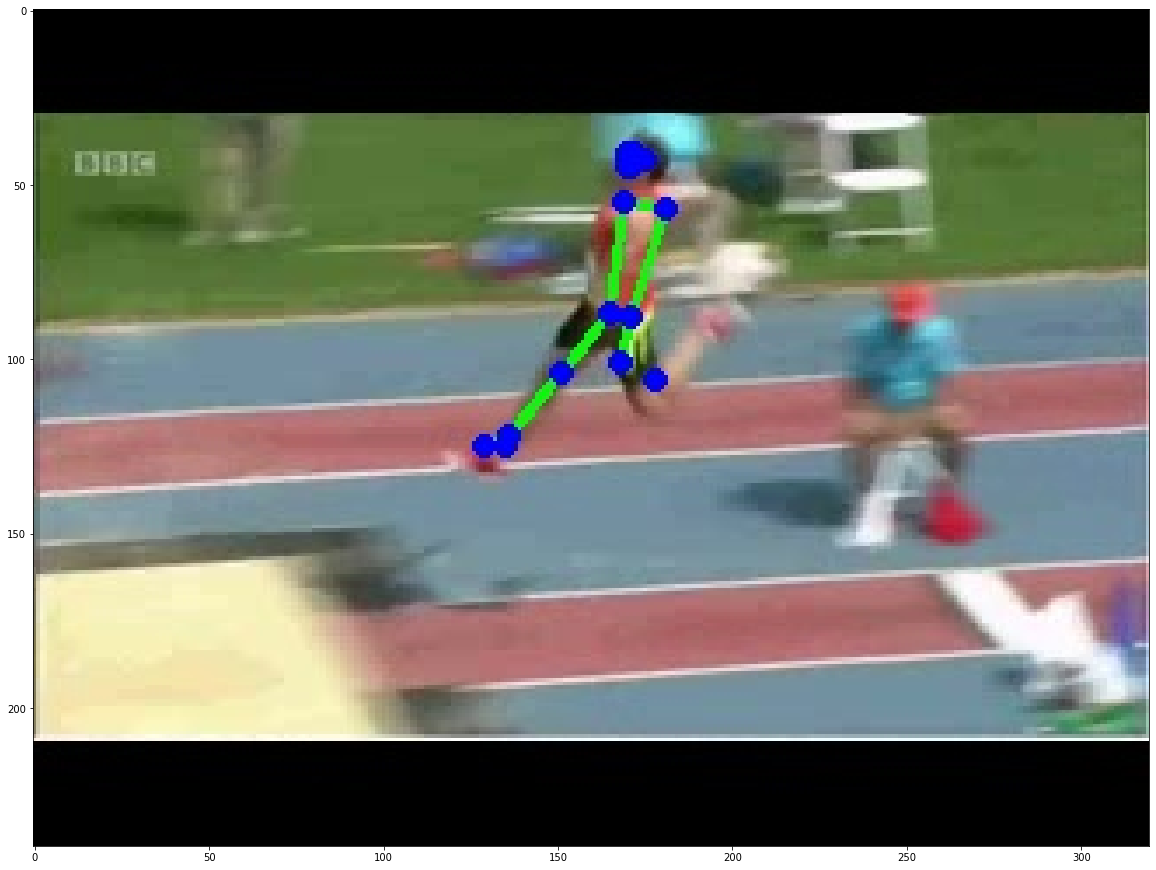

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\salto\salto_45.jpg
  sample class =    salto
  detected class =  ['correr']
  all classes =     {'salto': 2, 'correr': 8}


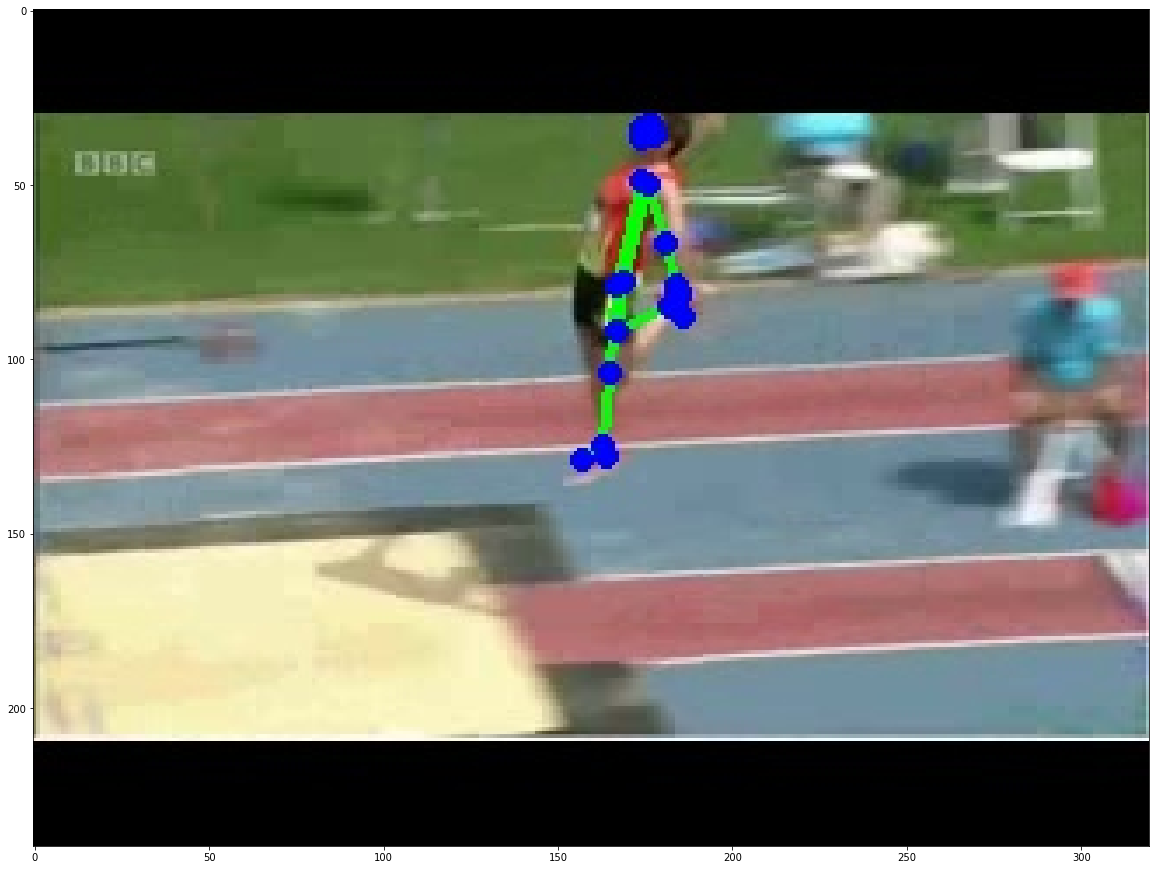

Outlier
  sample path =     ../Dataset/LongJumpFrames_out\salto\salto_46.jpg
  sample class =    salto
  detected class =  ['correr']
  all classes =     {'batida': 1, 'salto': 2, 'correr': 7}


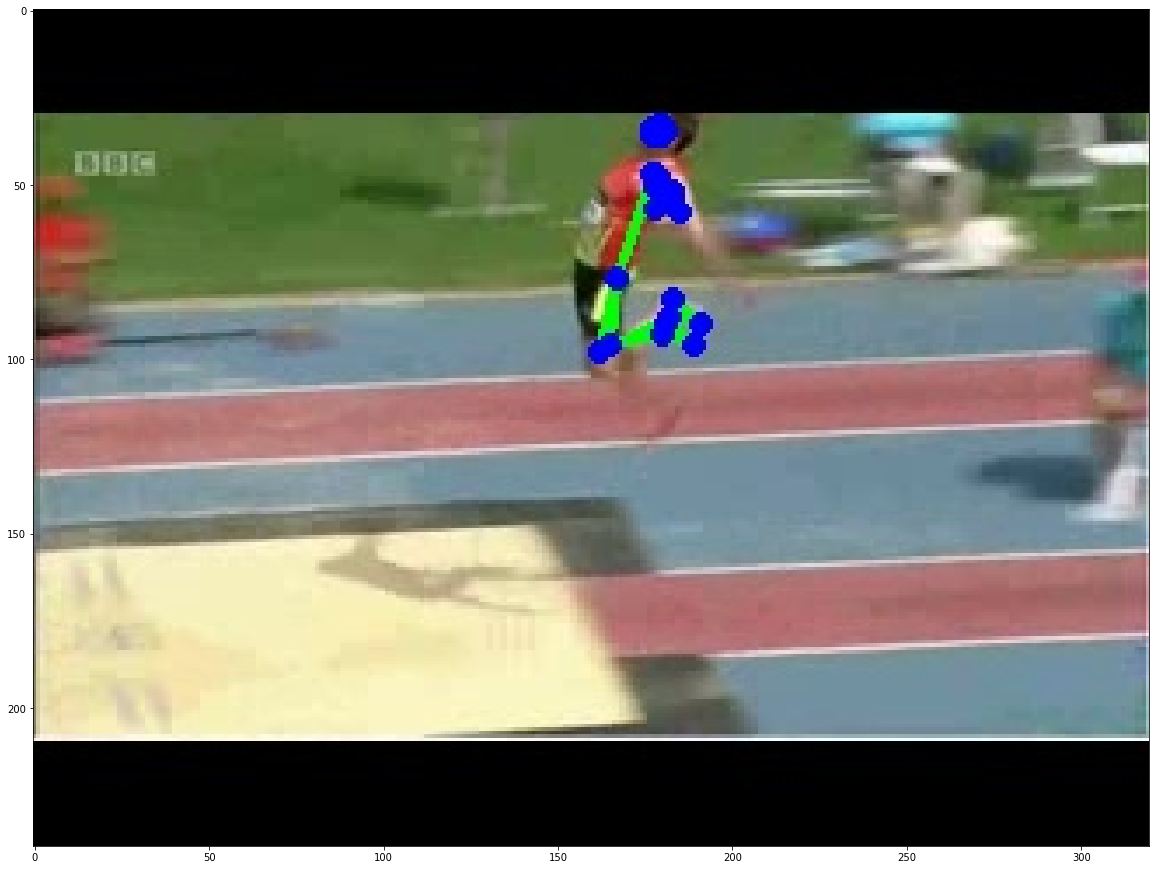

In [4]:
# Analyze outliers.
bootstrap_helper.analyze_outliers(outliers)

In [5]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [6]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  batida: 2
  correr: 44
  salto: 35


## Test clasificacion

In [6]:
# Specify your video name and target pose class to count the repetitions.
video_path = '../Dataset/UCF101/LongJump/v_LongJump_g01_c03.avi'
class_name=['correr','salto','batida']
out_video_path = 'correr-sample-out.mp4'

In [7]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [8]:
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose


# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = 'pose_csv'

# Initialize tracker.
pose_tracker = mp_pose.Pose(upper_body_only=False)

# Initialize embedder.
pose_embedder = FullBodyPoseEmbedder()

# Initialize classifier.
# Ceck that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
# outliers = pose_classifier.find_pose_sample_outliers()
# print('Number of pose sample outliers (consider removing them): ', len(outliers))

# Initialize EMA smoothing.
pose_classification_filter = EMADictSmoothing(
    window_size=10,
    alpha=0.2)

# Initialize counter.
repetition_counter = RepetitionCounter(
    class_name=class_name,
    enter_threshold=6,
    exit_threshold=4)

# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    class_name=class_name,
    plot_x_max=video_n_frames,
    # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
    plot_y_max=10)

In [18]:
# Run classification on a video.
import os
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from matplotlib import pyplot as plt


# Open output video.
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
  while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
        break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
          image=output_frame,
          landmark_list=pose_landmarks,
          connections=mp_pose.POSE_CONNECTIONS)
    
    if pose_landmarks is not None:
        # Get landmarks.
        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
        pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                    for lmk in pose_landmarks.landmark], dtype=np.float32)
        assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

        # Classify the pose on the current frame.
        pose_classification = pose_classifier(pose_landmarks)

        # Smooth classification using EMA.
        pose_classification_filtered = pose_classification_filter(pose_classification)

        # Count repetitions.
        #  repetitions_count = repetition_counter(pose_classification_filtered)
        repetitions_count=0
    else:
        # No pose => no classification on current frame.
        pose_classification = None

        # Still add empty classification to the filter to maintaing correct
        # smoothing for future frames.
        pose_classification_filtered = pose_classification_filter(dict())
        pose_classification_filtered = None

        # Don't update the counter presuming that person is 'frozen'. Just
        # take the latest repetitions count.
        #  repetitions_count = repetition_counter.n_repeats
        repetitions_count=0

    # Draw classification plot and repetition counter.
    output_frame = pose_classification_visualizer(
        frame=output_frame,
        pose_classification=pose_classification,
        pose_classification_filtered=pose_classification_filtered,
        repetitions_count=repetitions_count)

    # Save the output frame.
    out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

    # Show intermediate frames of the video to track progress.
    if frame_idx % 50 == 0:
        plt.imshow(output_frame)
        plt.show()
        # show_image(output_frame)

    frame_idx += 1
    pbar.update()

# Close output video.
out_video.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
if output_frame is not None:
    plt.imshow(output_frame)
    plt.show()
    # show_image(output_frame)

  0%|          | 0/142.0 [00:00<?, ?it/s]


TypeError: unhashable type: 'list'